# Detrending and Sigma Clipping Light Curves

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import sys

We need to make sure the plots look a little nicer. 

In [2]:
try:
    plt.style.use('./jupyter.mplstyle')
except:
    import matplotlib as mpl
    mpl.rcParams['figure.figsize'] = 16, 6
    mpl.rcParams['font.sans-serif'] = 'Arial, Liberation Sans, DejaVu Sans, Bitstream Vera Sans, sans-serif'
    mpl.rcParams['font.family'] = 'sans-serif'
    mpl.rcParams['font.size'] = 16

Next, we set the directories and object name.

In [3]:
obj='8430'
localdir='/Users/user/Stars/objects/rg/gaulme/8430105'
files = localdir+'/raw_data'  
all_detrended = localdir + '/detrended/'+obj+'detrended_all_gps.dat'

Prepare the output file:

In [4]:
f = open(all_detrended,"w+")
f.write("# BJD, flux, uncertainty \n")
f.close()

This function calculates the baseline of the data by fitting a polynomial. This is applied to the data with the eclipses removed using sig clip.

In [5]:
def calc_baseline(initial_sigma,d,order,xi_lo,xi_hi):
    coeffs = np.polynomial.legendre.legfit(d[:,0], d[:,1], order, w=d[:,2])
    baseline = np.polynomial.legendre.legval(d[:,0], coeffs, tensor=False)
    flt = (d[:,1]-baseline < xi_hi*initial_sigma) & (d[:,1]-baseline > -xi_lo*initial_sigma)
    return flt,baseline

This function removes the eclipses from the data in preparation to fit the baseline to the outer envelope. We then use the original data combined with this baseline to generate the residuals. 

In [6]:
def sigclip(d,initial_sigma,xi_lo,xi_hi,order):
    flt,baseline=calc_baseline(initial_sigma,d,order,xi_lo,xi_hi)
    culled_data = d[flt]
    culled_points = len(d)-len(culled_data)
    print(f'{culled_points} datapoints culled')
    sig_clip_data = d[flt]
    while culled_points > 0:
        flt,baseline=calc_baseline(initial_sigma,culled_data,order,xi_lo,xi_hi)
        culled_points = len(culled_data)-len(culled_data[flt])
        culled_data = culled_data[flt]
        print(f'{culled_points} datapoints culled')
    plt.plot(d[:,0], d[:,1], 'b.')
    plt.plot(culled_data[:,0], culled_data[:,1], 'g.')
    plt.plot(culled_data[:,0], baseline, 'r-')
    plt.xlabel("Time (scaled between 0 and 1)")
    plt.ylabel("Flux")
    plt.title("Initial Sigma Clip to Remove Eclipses and Fit the Baseline")
    plt.show()
    return culled_data[:,0],baseline

We run a final sig clip to actually remove unwanted outliers. This version should be less agressive so that we keep the eclipses. 

In [7]:
def final_sig_clip(d,baseline_x,baseline_y,xi_lo,xi_hi):      
    initial_sigma = np.nanstd(d[:,1])
    new_baseline = np.interp(d[:,0],baseline_x,baseline_y)
    flt = (d[:,1]-new_baseline < xi_hi*initial_sigma) & (d[:,1]-new_baseline > -xi_lo*initial_sigma)
    culled_data = d[flt]
    new_baseline=new_baseline[flt]
    plt.plot(d[:,0], d[:,1], 'b.')
    plt.plot(culled_data[:,0], culled_data[:,1], 'g.')
    plt.plot(culled_data[:,0], new_baseline, 'r-')
    plt.xlabel("Time scaled between 0 and 1")
    plt.ylabel("Flux")
    plt.title("Final Sigma Clip to Remove Spurious Points")
    plt.show()
    return culled_data, new_baseline

This function incorporates all the necessary steps to detrend a single lightcurve. The sigma values will need to be adjusted for your needs. The data are expected to have the following columns: data[:,0] is expected to be time, data[:,1] is expected to be flux, data[:,2] is expected to be flux error.

In [15]:
def detrend(data):
    arg = np.where((data[:,1]!= float('-inf')) & (data[:,1]!= float('inf')) & (data[:,3]!= float('-inf')) & (data[:,3]!= float('inf')))
    d=np.empty([len(data[:,1][arg]),4])
    d[:,0]=data[:,0][arg] #Time
    d[:,1]=data[:,1][arg] #Raw Flux
    d[:,2]=data[:,2][arg] #Raw Flux Error
    tmin, tmax = d[:,0][0], d[:,0][-1]
    d[:,0] = (d[:,0]-tmin)/(tmax-tmin)
    print ("start time of data = ", tmax)
    print ("end time of data = ", tmin)
    initial_sigma = np.std(d[:,1])
    ############################################
    #Change these values according to your data#
    #xi_hi = the number of sigma above the fitted curve beyond which you'll remove data points
    #xi_lo = the number of sigma below the fitted curve beyond which you'll remove data points

    order = 13
    xi_hi = 1.5 
    xi_lo = 0.2
    final_xi_hi = 1.5
    final_xi_lo = 3.
    ############################################
    baseline_x, baseline_y=sigclip(d,initial_sigma,xi_lo,xi_hi,order)
    culled_data, new_baseline = final_sig_clip(d,baseline_x,baseline_y,final_xi_lo,final_xi_hi)
    times = [tmin + element * (tmax-tmin) for element in culled_data[:,0]]
    old_times = [tmin + element * (tmax-tmin) for element in d[:,0]]
    residuals = culled_data[:,1]/new_baseline
    plt.plot(old_times, d[:,1]/np.median(d[:,1]), 'g.')
    plt.plot(times,residuals,'b.')
    plt.title("Detrended Lightcurve with Spurious Points Removed")
    plt.xlabel("time (days)")
    plt.ylabel("Relative Flux")
    plt.show()
    uncert = culled_data[:,2]/np.median(culled_data[:,1])
    all_data=np.asarray([times, residuals, uncert]).transpose()
    return all_data
    

This is the main function that reads in all the data (.dat) files in a directory that start with "kplr" and detrends each light curve. All detrended light curves are appended to a single file. Adjust the file names accordingly.

/Users/user/Stars/objects/rg/gaulme/8430105/raw_data/kplr008430105-2010078095331_llc.dat
start time of data =  55275.2028748
end time of data =  55185.3972223
183 datapoints culled
22 datapoints culled
1 datapoints culled
0 datapoints culled


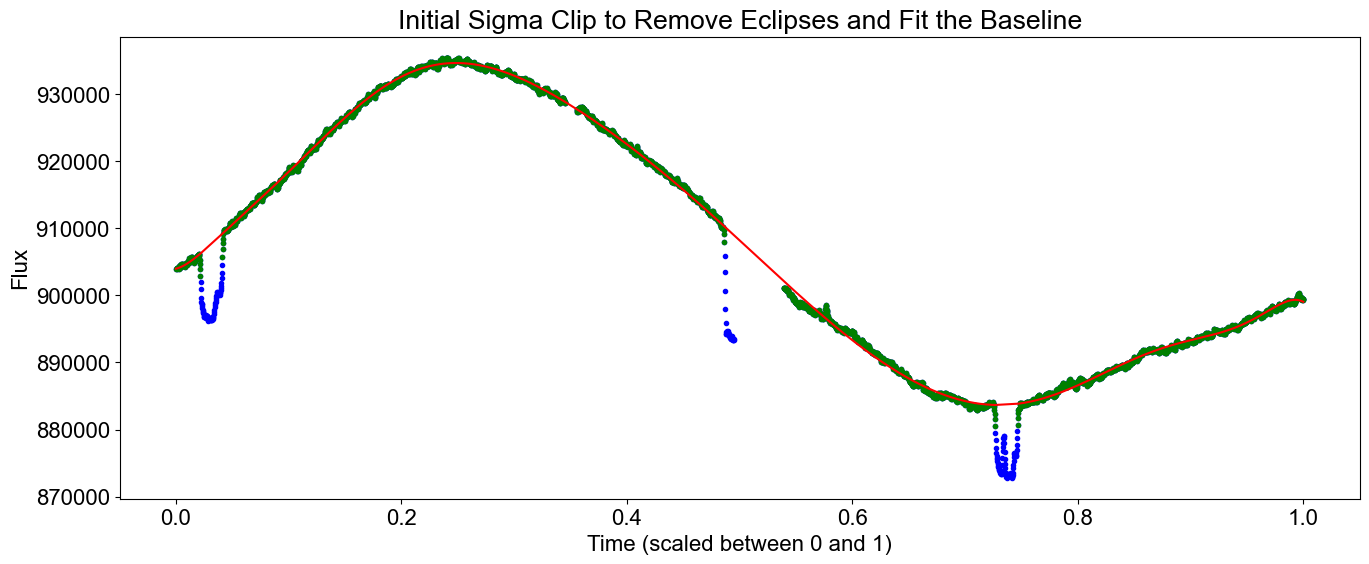

/Users/user/Stars/objects/rg/gaulme/8430105/raw_data/kplr008430105-2010174085026_llc.dat
start time of data =  55371.162607
end time of data =  55276.5106643
247 datapoints culled
9 datapoints culled
0 datapoints culled


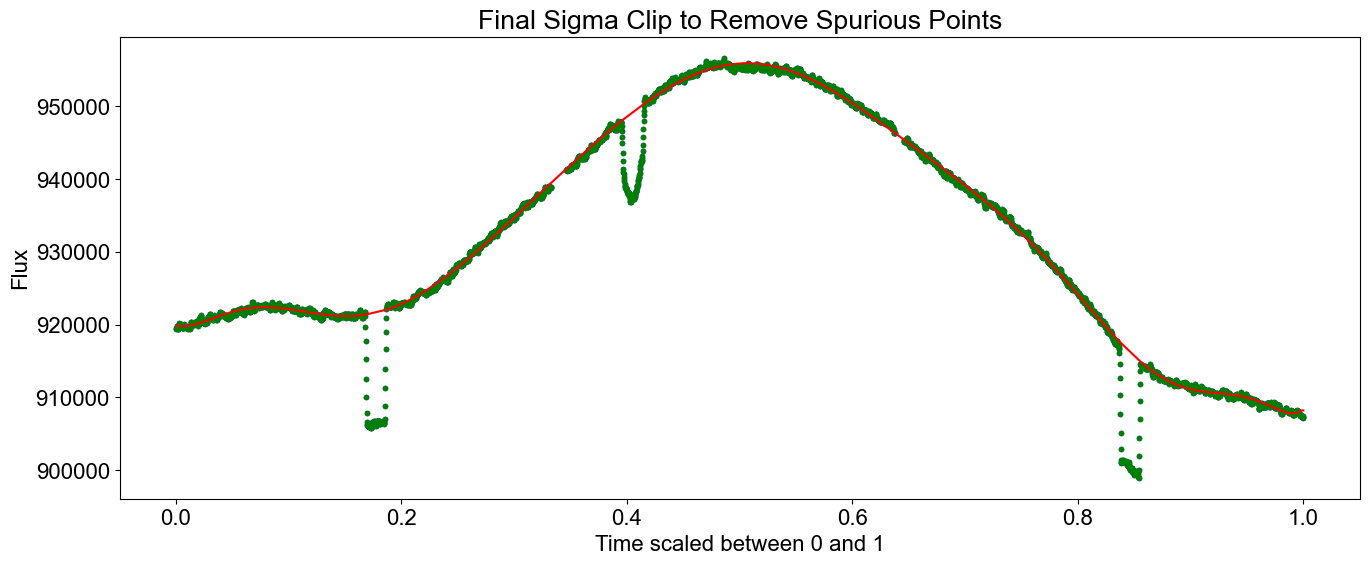

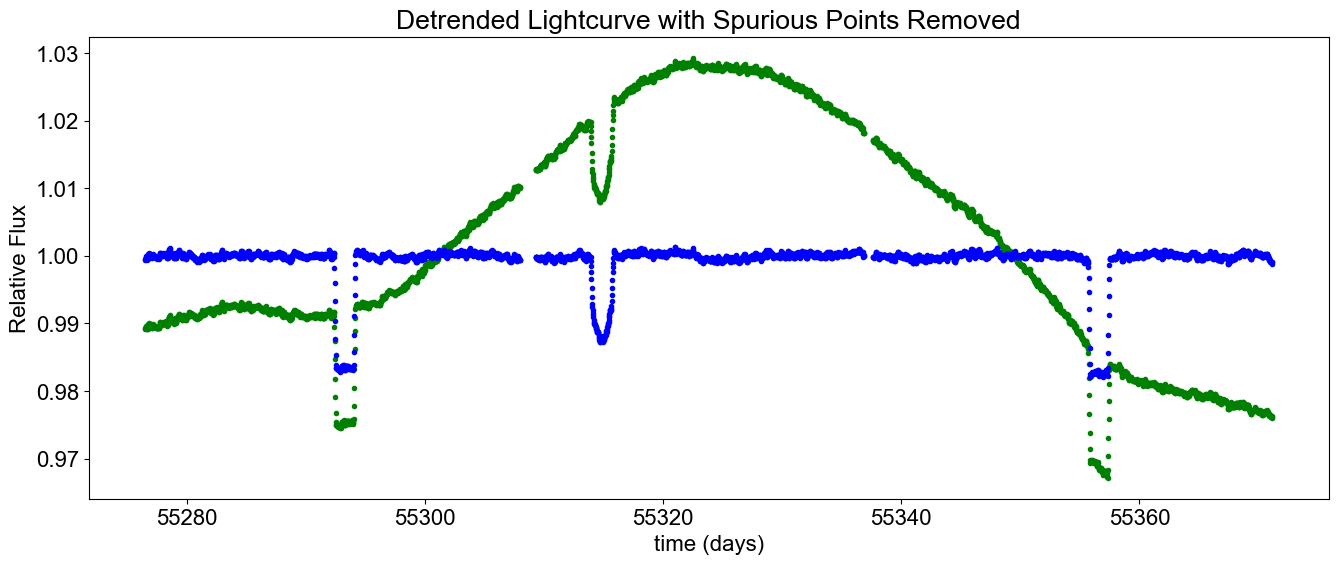

/Users/user/Stars/objects/rg/gaulme/8430105/raw_data/kplr008430105-2012088054726_llc.dat
start time of data =  56015.021653
end time of data =  55932.4290516
252 datapoints culled
17 datapoints culled
2 datapoints culled
0 datapoints culled


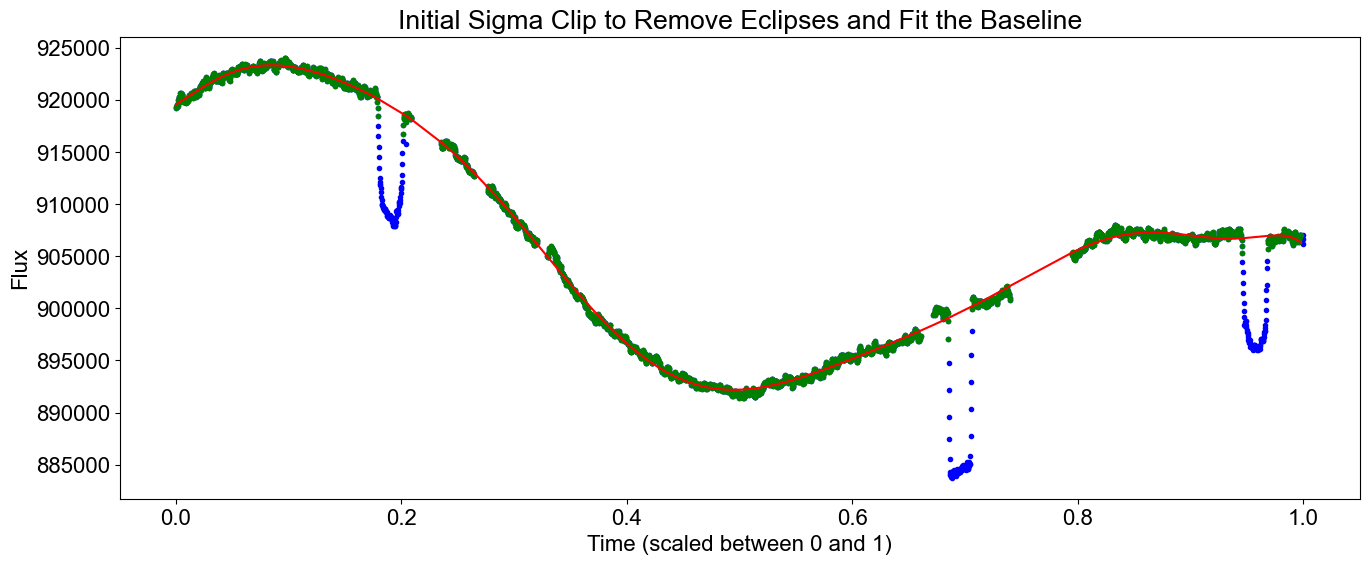

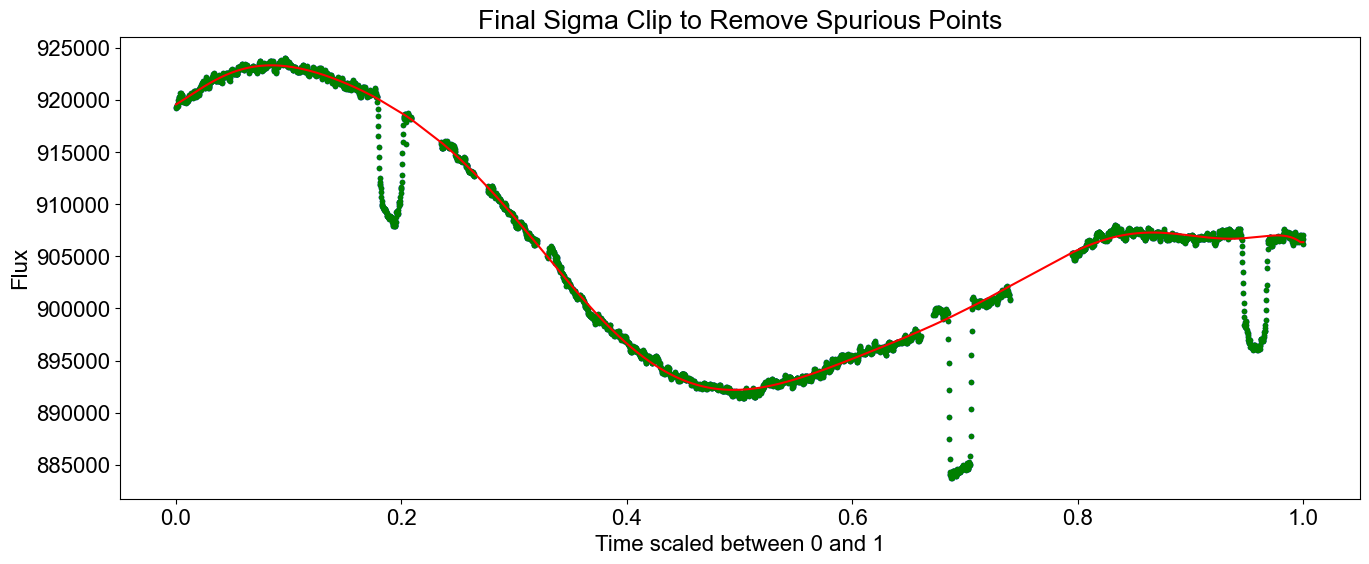

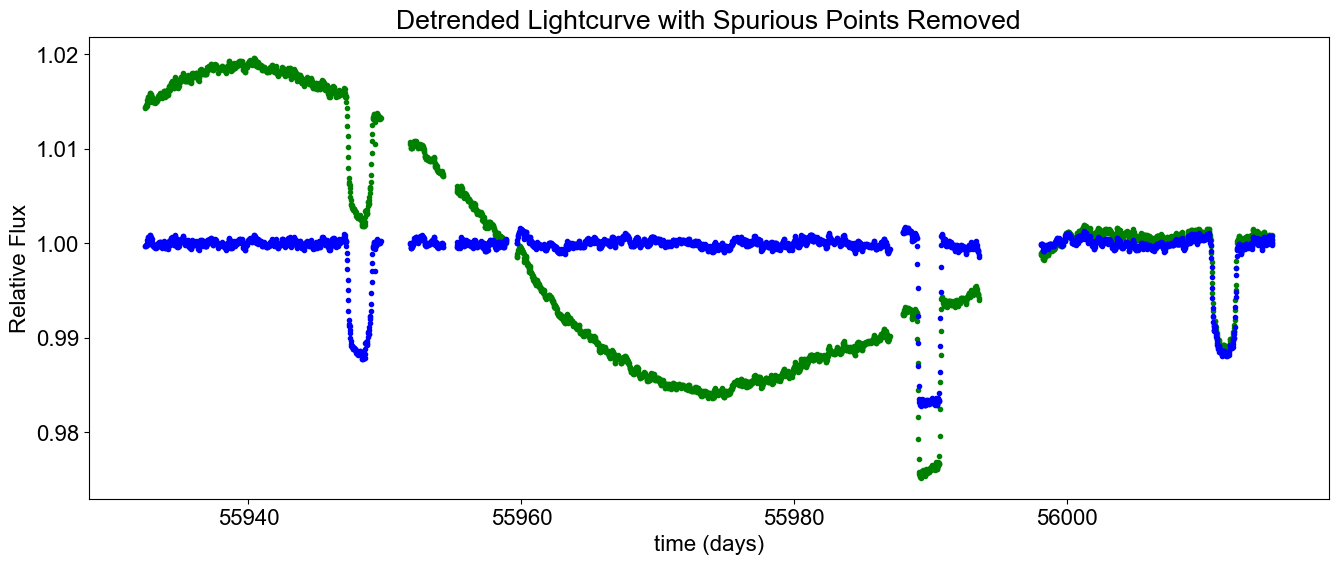

/Users/user/Stars/objects/rg/gaulme/8430105/raw_data/kplr008430105-2009166043257_llc.dat
start time of data =  54997.9837141
end time of data =  54964.5122872
89 datapoints culled
6 datapoints culled
1 datapoints culled
0 datapoints culled


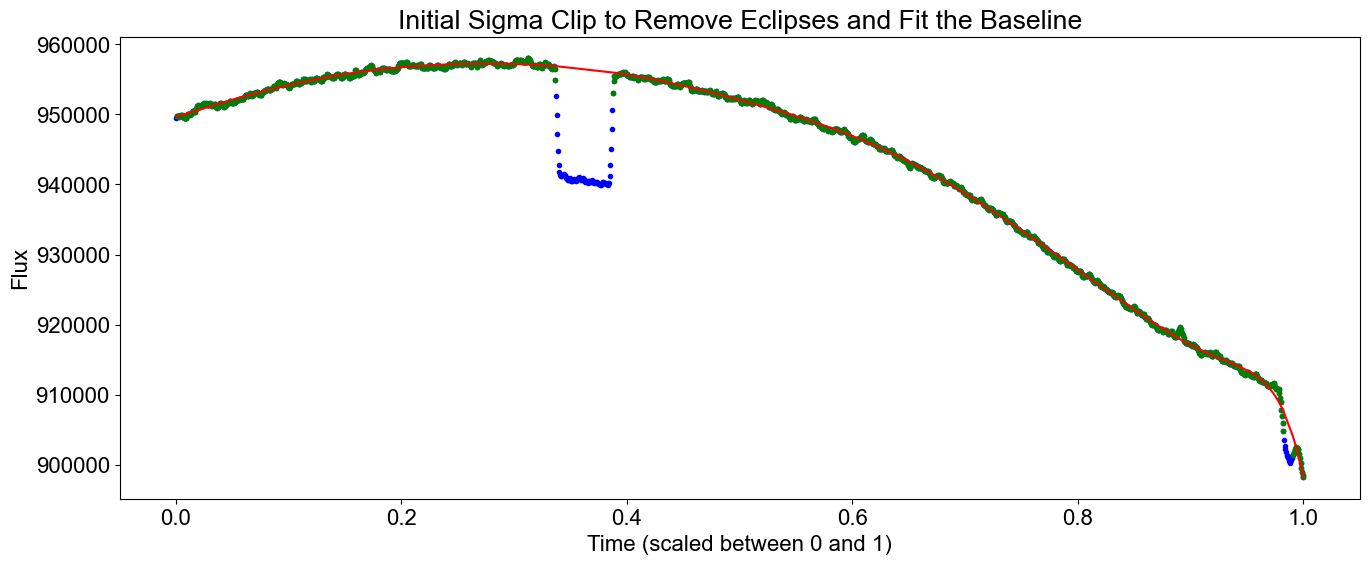

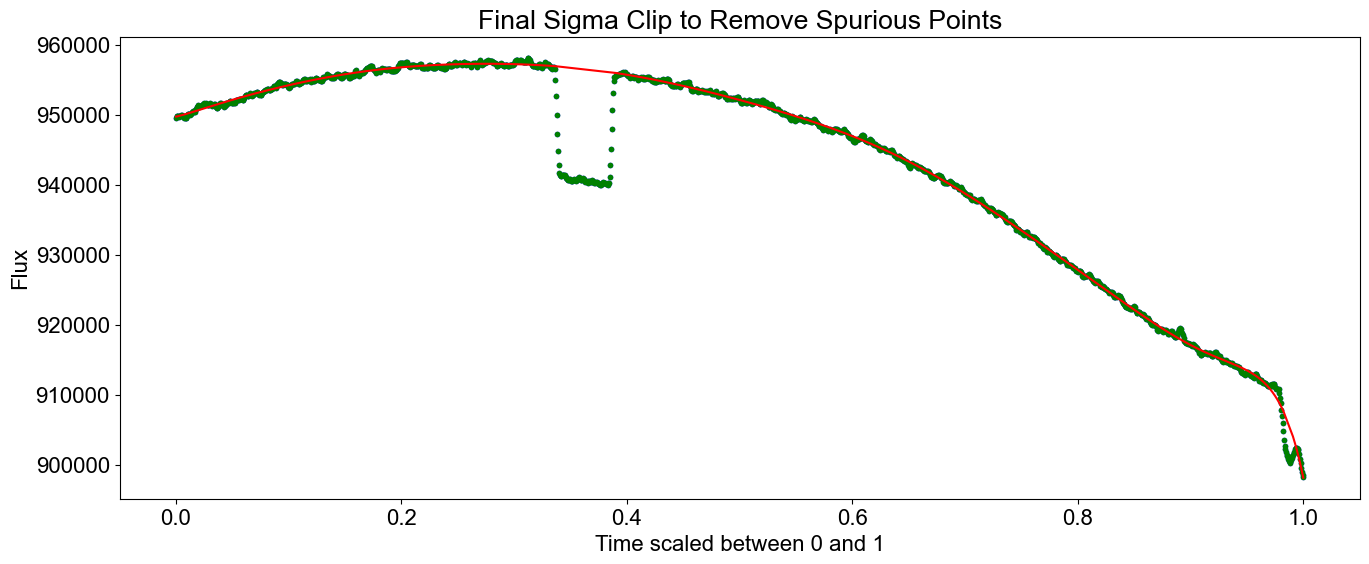

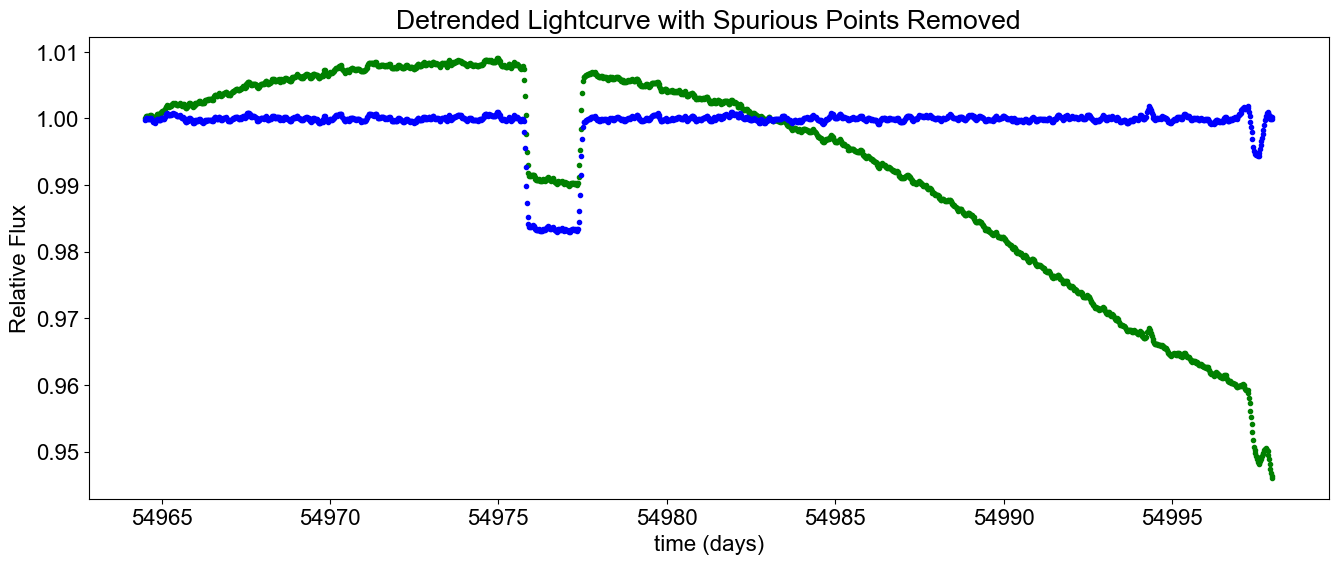

/Users/user/Stars/objects/rg/gaulme/8430105/raw_data/kplr008430105-2010265121752_llc.dat
start time of data =  55462.2965249
end time of data =  55372.4703752
239 datapoints culled
13 datapoints culled
1 datapoints culled
0 datapoints culled


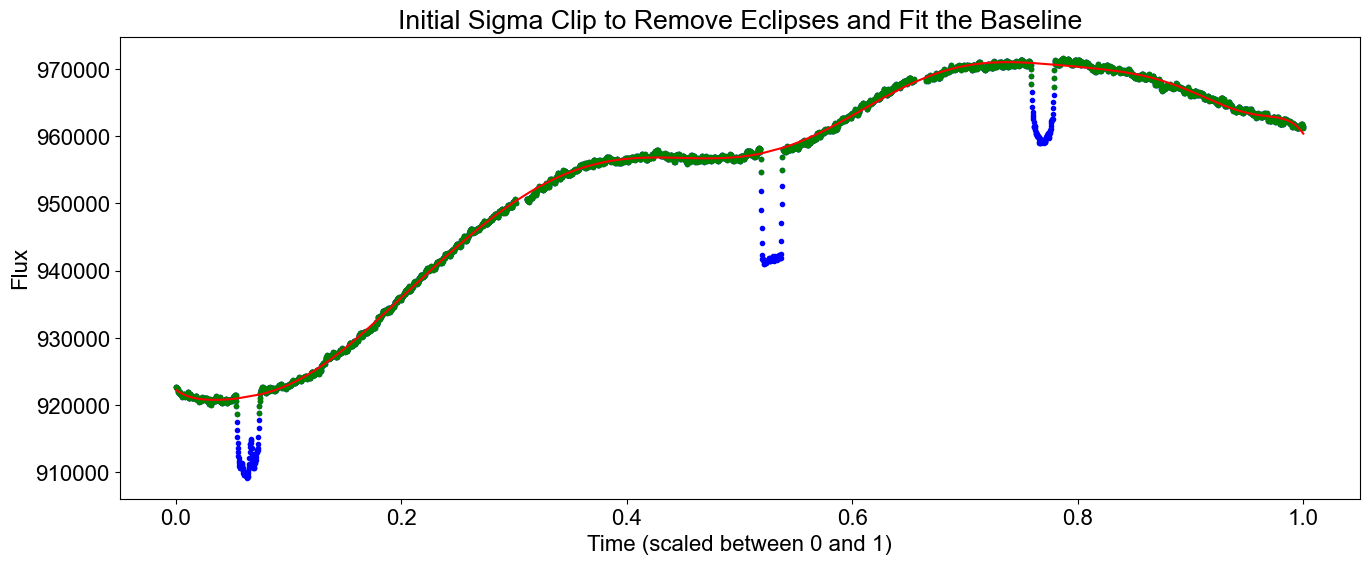

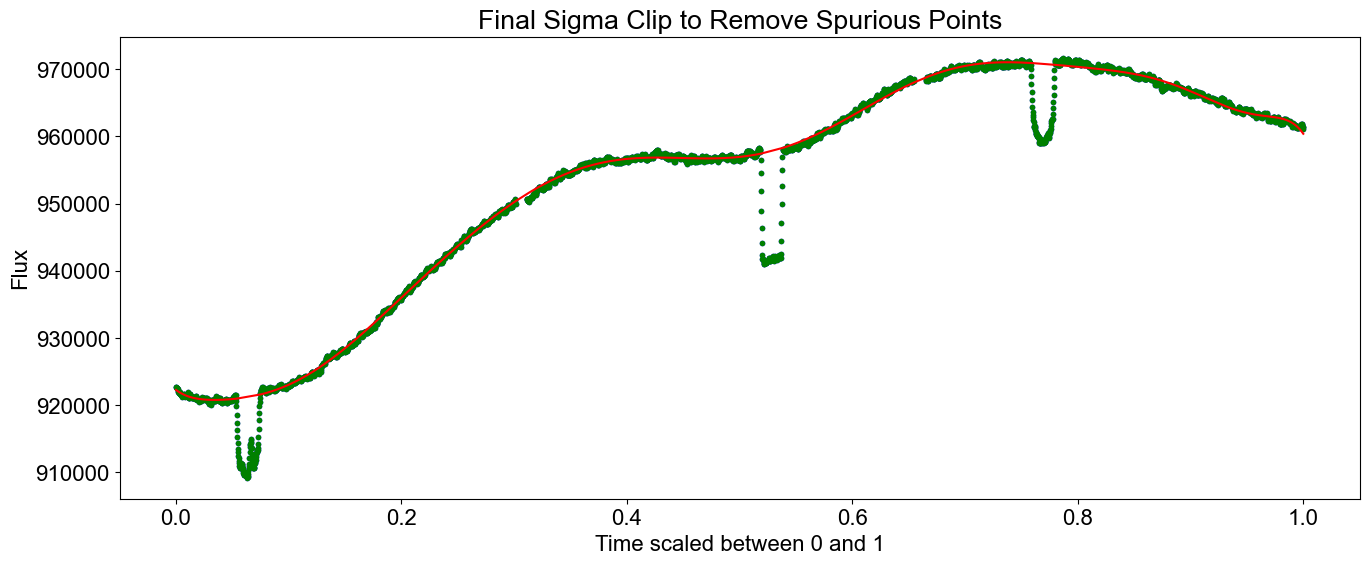

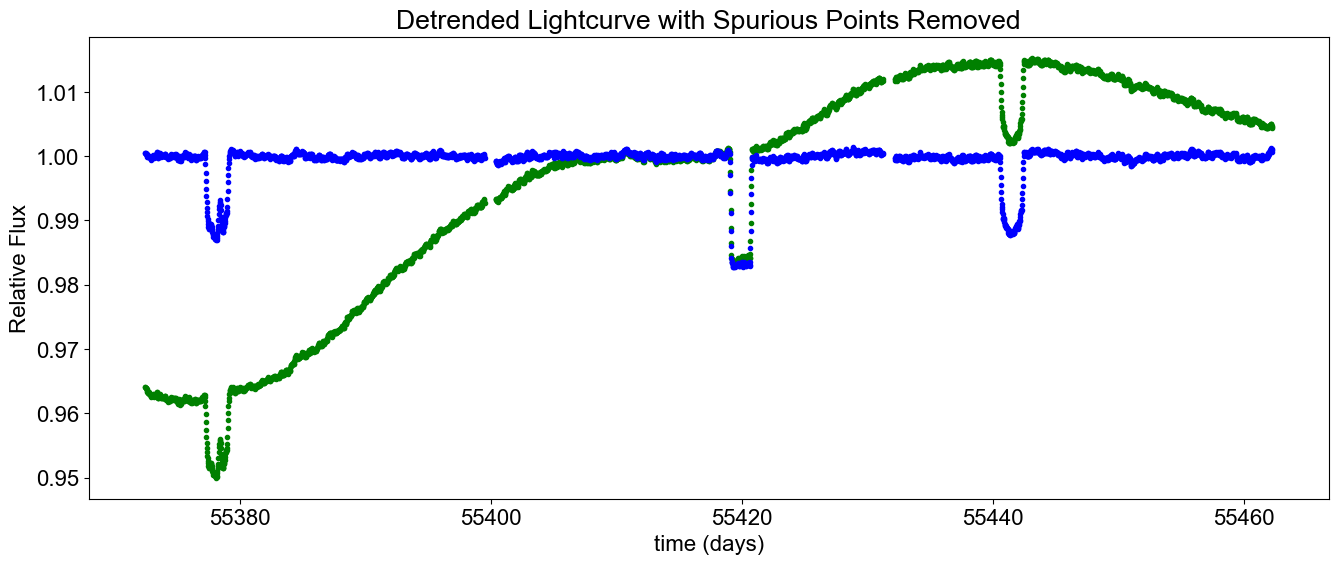

/Users/user/Stars/objects/rg/gaulme/8430105/raw_data/kplr008430105-2012179063303_llc.dat
start time of data =  56106.0567139
end time of data =  56015.7572507
250 datapoints culled
6 datapoints culled
1 datapoints culled
0 datapoints culled


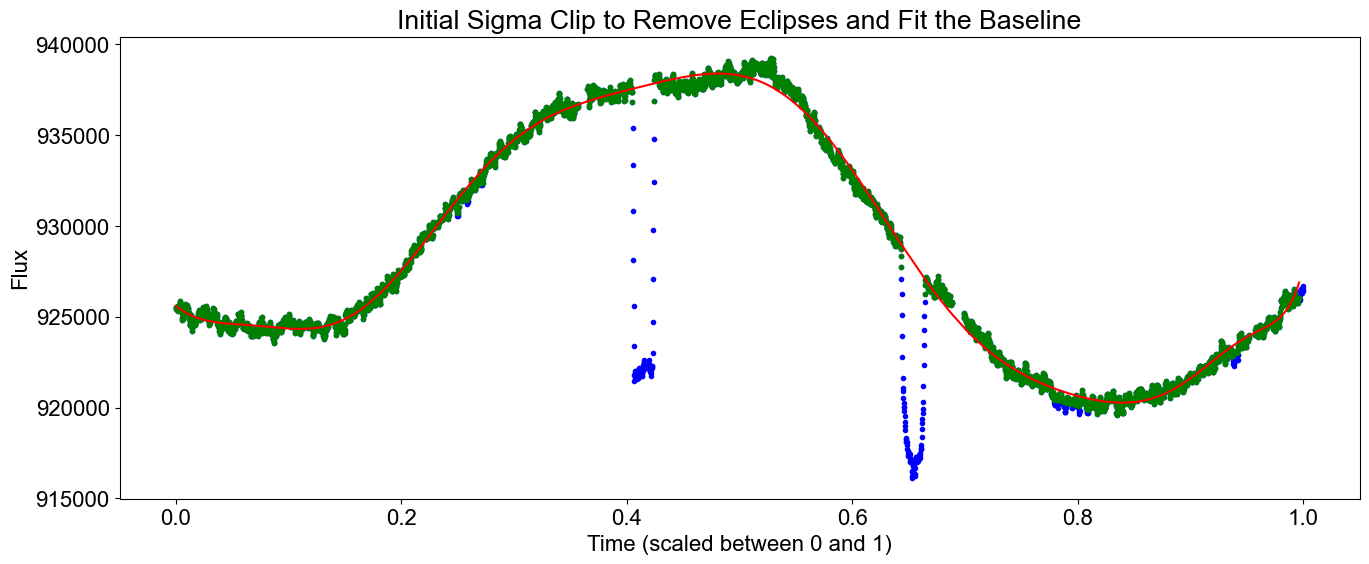

/Users/user/Stars/objects/rg/gaulme/8430105/raw_data/kplr008430105-2011073133259_llc.dat
start time of data =  55635.3447562
end time of data =  55568.3838561
181 datapoints culled
14 datapoints culled
3 datapoints culled
3 datapoints culled
2 datapoints culled
3 datapoints culled
1 datapoints culled
3 datapoints culled
3 datapoints culled
2 datapoints culled
1 datapoints culled
0 datapoints culled


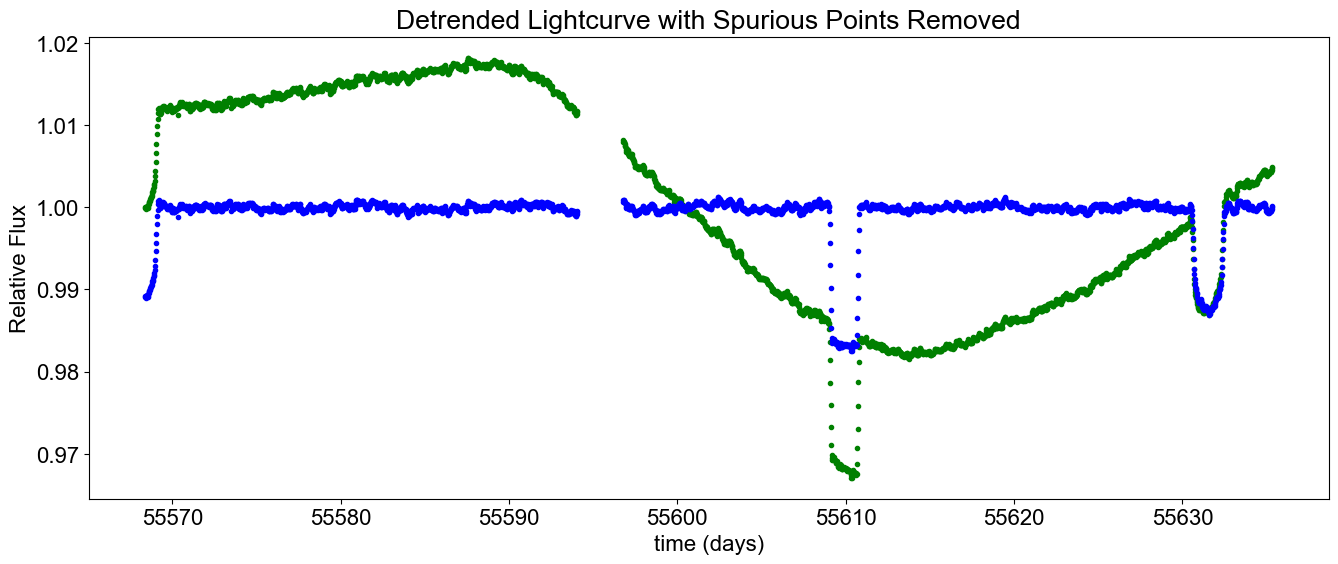

/Users/user/Stars/objects/rg/gaulme/8430105/raw_data/kplr008430105-2012277125453_llc.dat
start time of data =  56204.3223178
end time of data =  56107.160134
402 datapoints culled
18 datapoints culled
0 datapoints culled


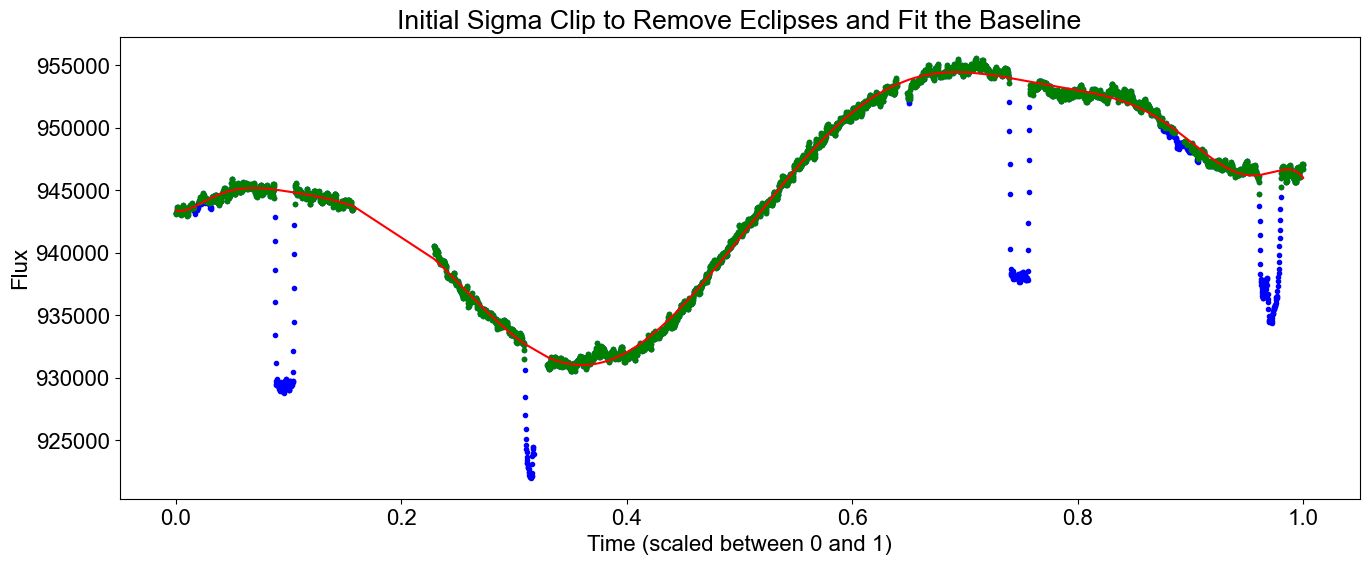

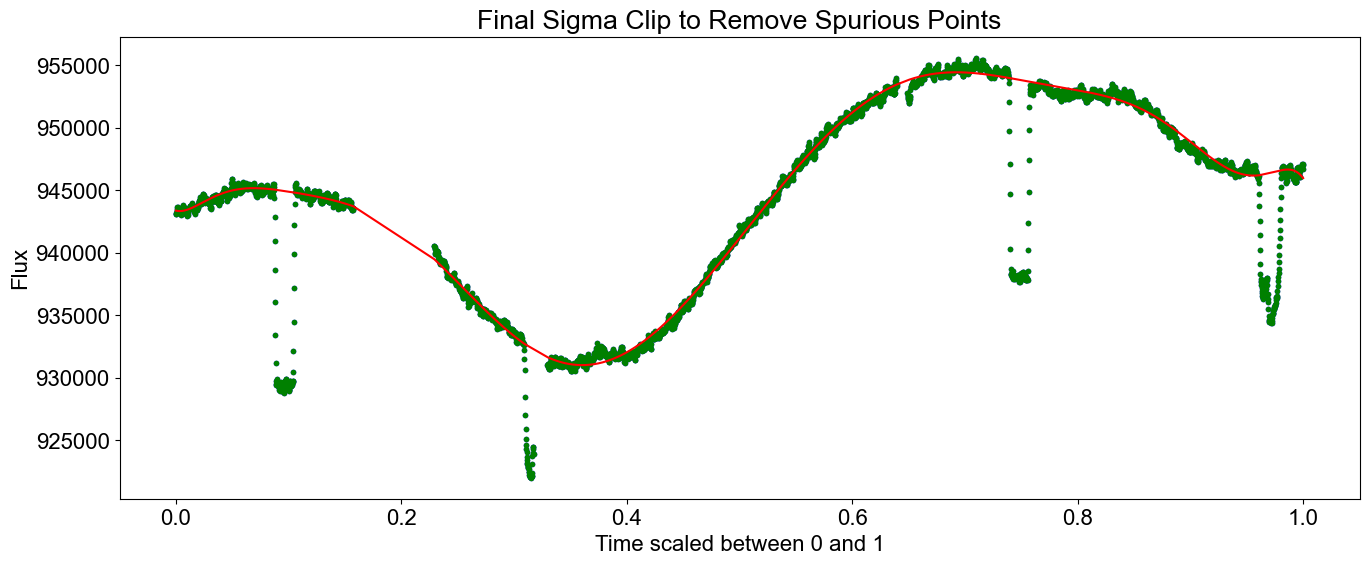

/Users/user/Stars/objects/rg/gaulme/8430105/raw_data/kplr008430105-2011177032512_llc.dat
start time of data =  55738.9264153
end time of data =  55641.5362784
307 datapoints culled
10 datapoints culled
2 datapoints culled
0 datapoints culled


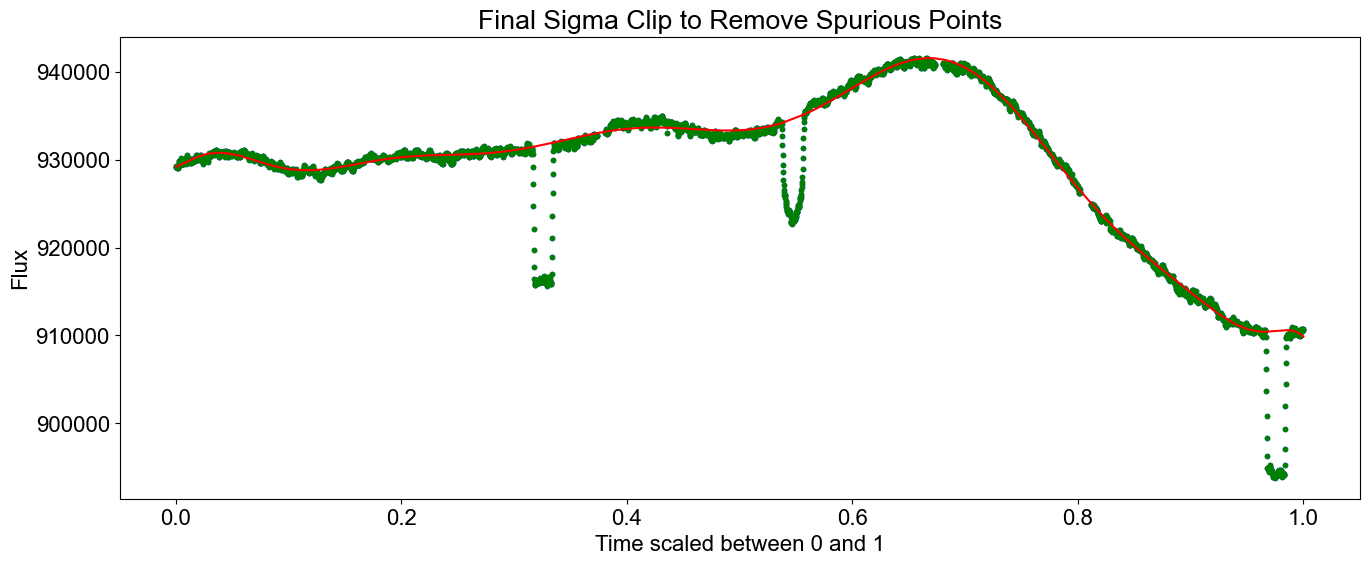

/Users/user/Stars/objects/rg/gaulme/8430105/raw_data/kplr008430105-2009131105131_llc.dat
start time of data =  54963.2453537
end time of data =  54953.5389996
0 datapoints culled


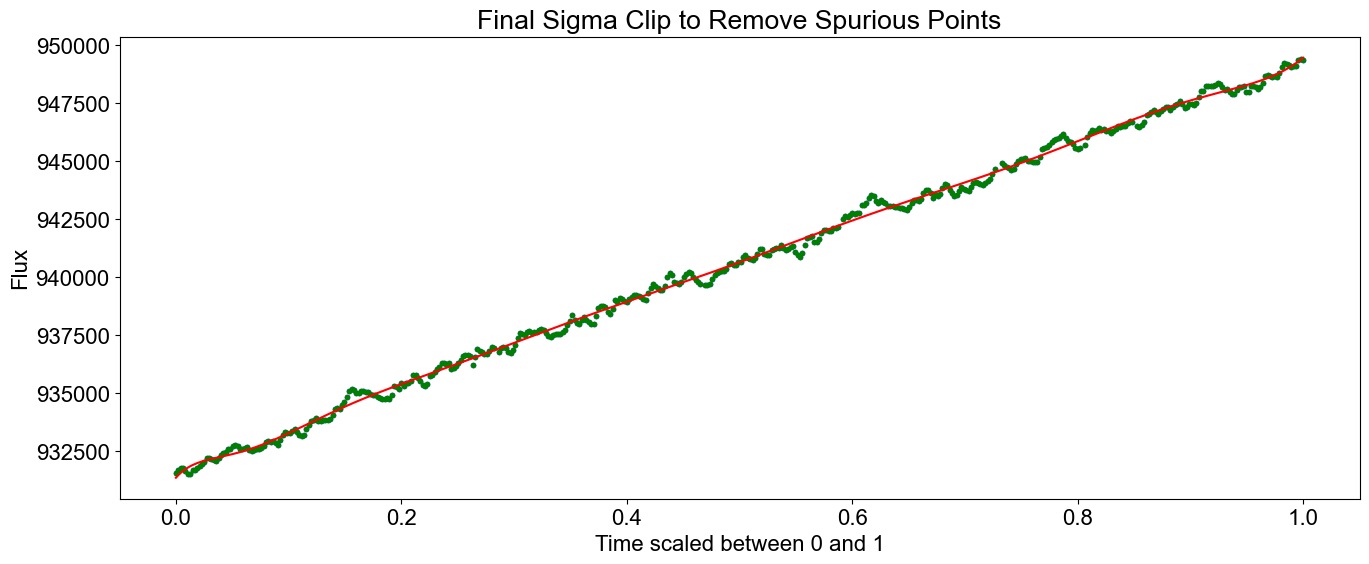

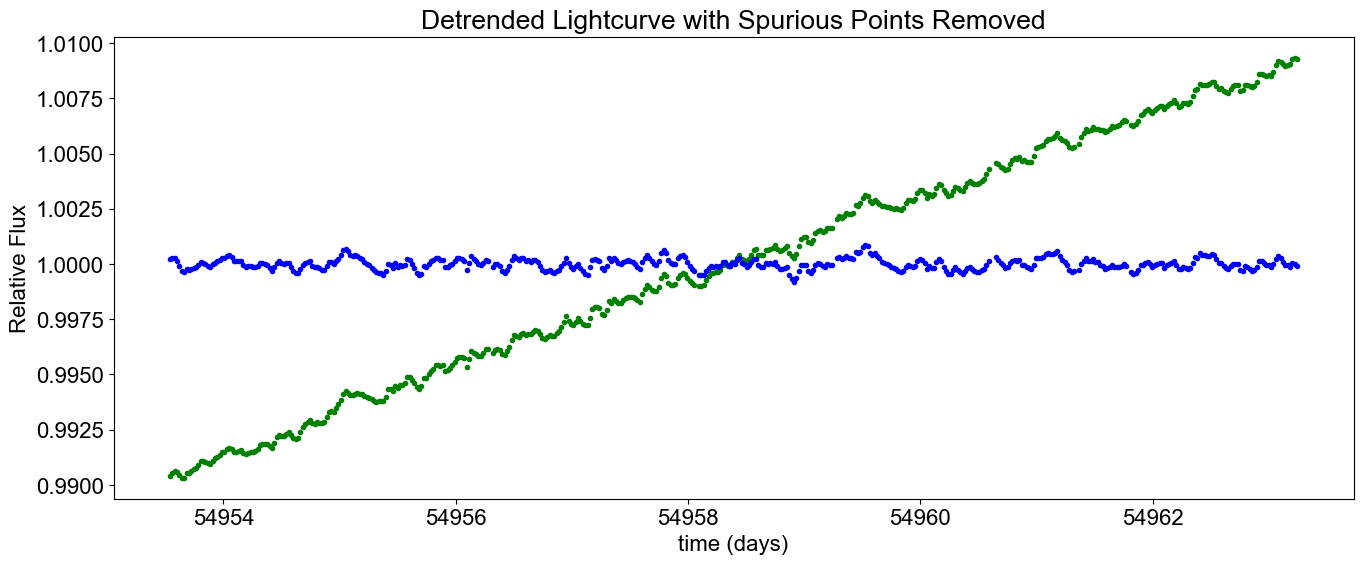

/Users/user/Stars/objects/rg/gaulme/8430105/raw_data/kplr008430105-2012004120508_llc.dat
start time of data =  55931.3256763
end time of data =  55834.2288934
349 datapoints culled
11 datapoints culled
1 datapoints culled
0 datapoints culled


/Users/user/Stars/objects/rg/gaulme/8430105/raw_data/kplr008430105-2013131215648_llc.dat
start time of data =  56424.0013686
end time of data =  56392.246418
33 datapoints culled
3 datapoints culled
0 datapoints culled


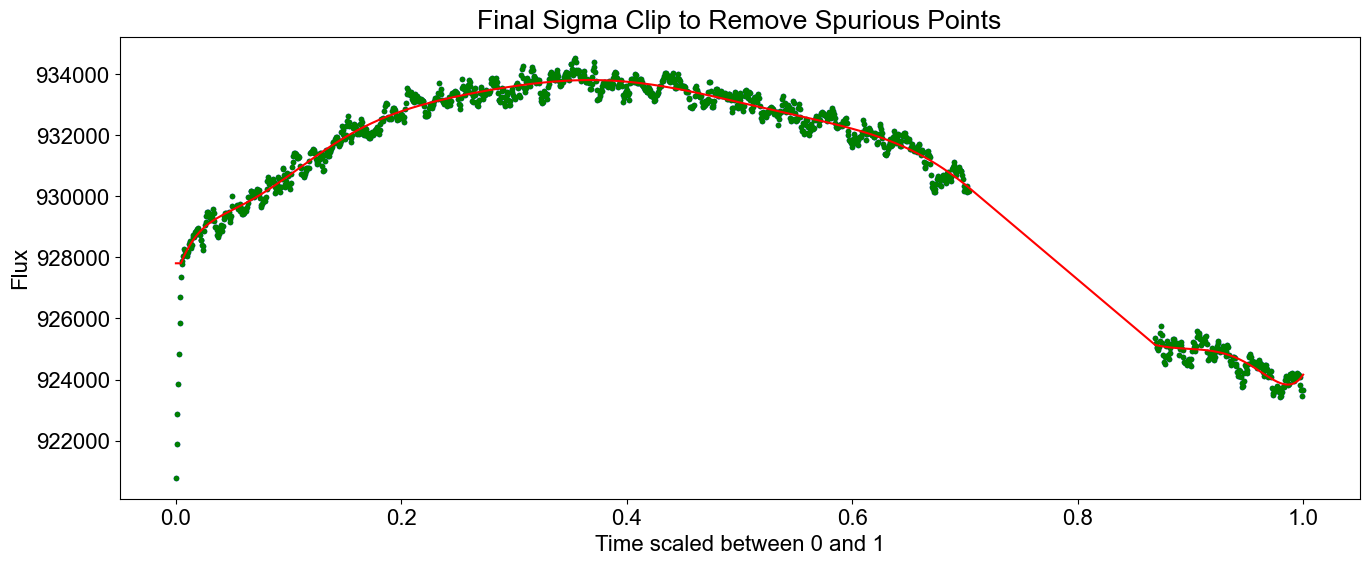

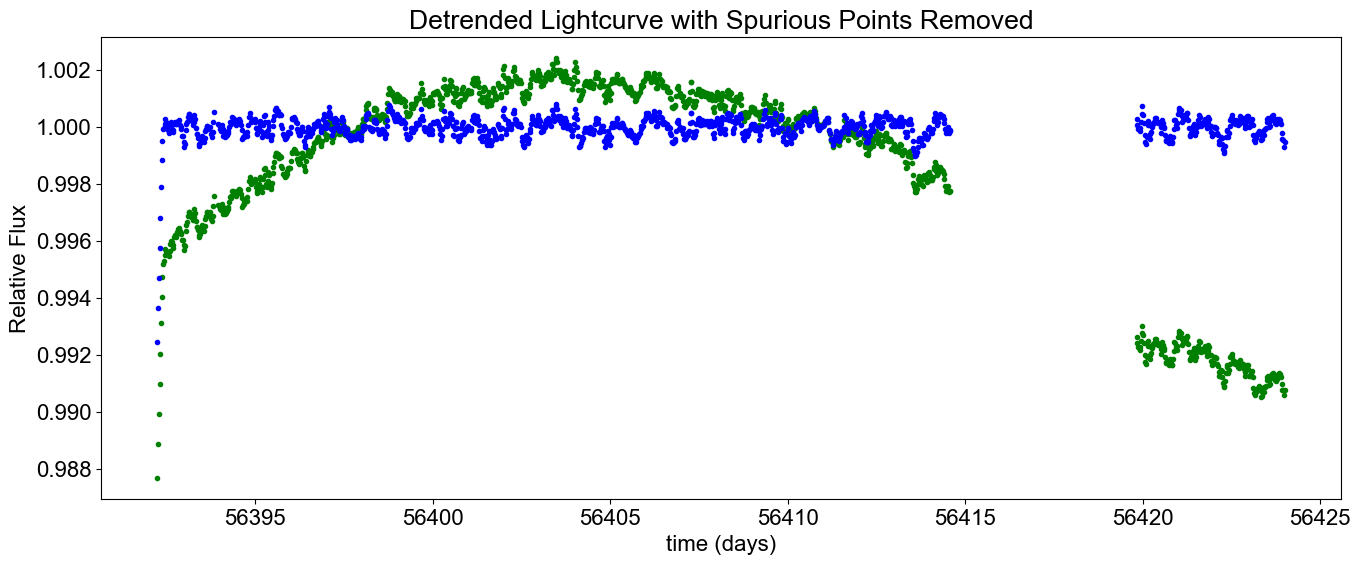

/Users/user/Stars/objects/rg/gaulme/8430105/raw_data/kplr008430105-2013011073258_llc.dat
start time of data =  56304.1366747
end time of data =  56206.5086245
196 datapoints culled
5 datapoints culled
0 datapoints culled


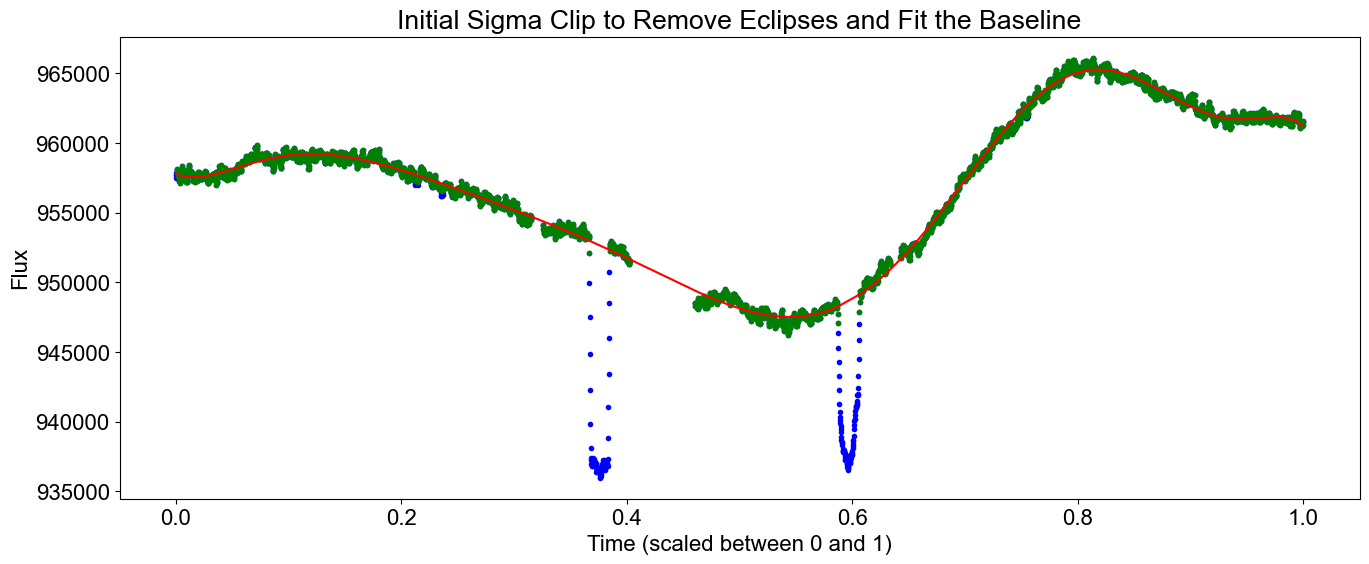

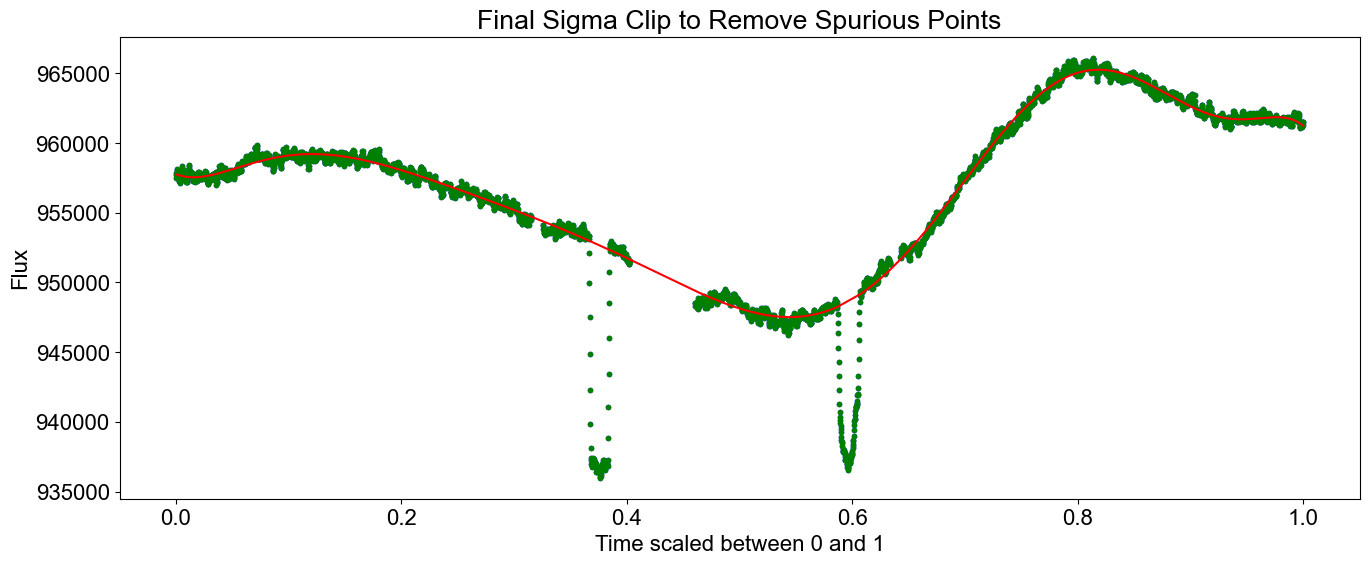

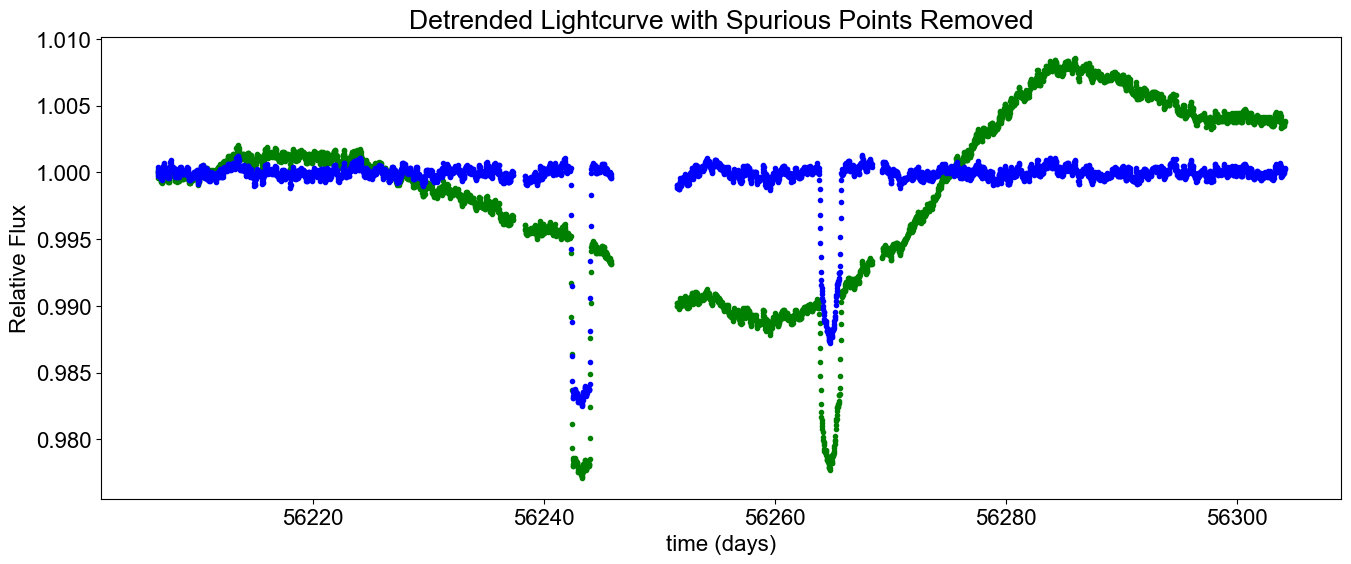

/Users/user/Stars/objects/rg/gaulme/8430105/raw_data/kplr008430105-2011271113734_llc.dat
start time of data =  55833.2685704
end time of data =  55739.8663568
261 datapoints culled
14 datapoints culled
0 datapoints culled


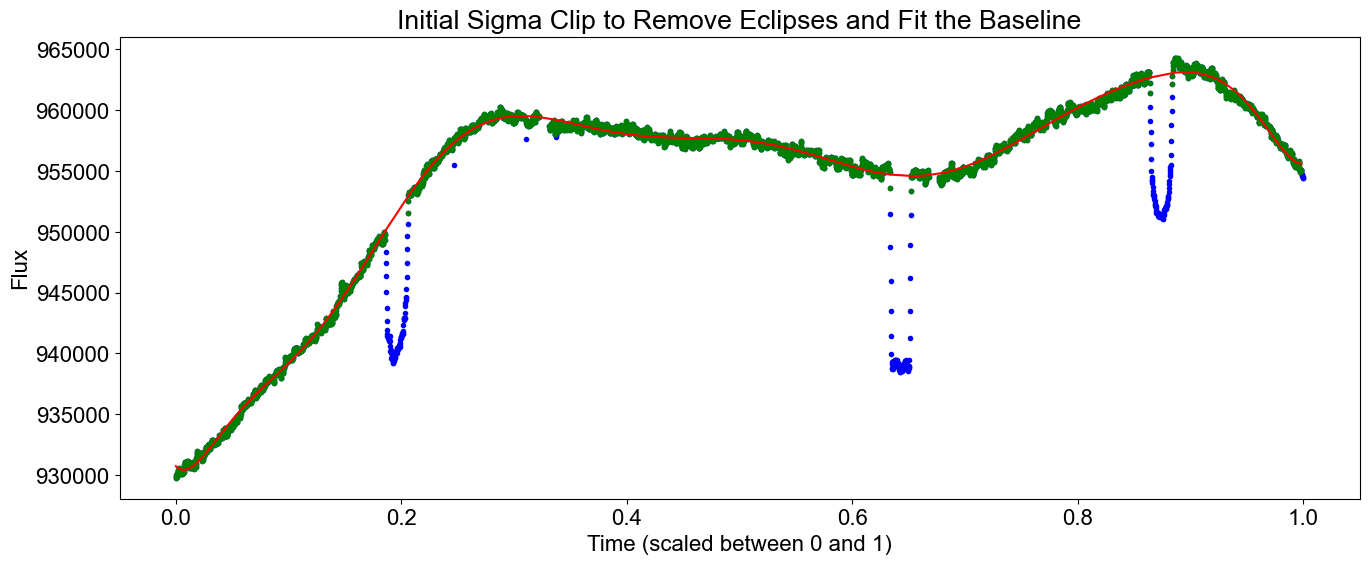

/Users/user/Stars/objects/rg/gaulme/8430105/raw_data/kplr008430105-2009350155506_llc.dat
start time of data =  55182.4957428
end time of data =  55093.2452394
223 datapoints culled
8 datapoints culled
0 datapoints culled


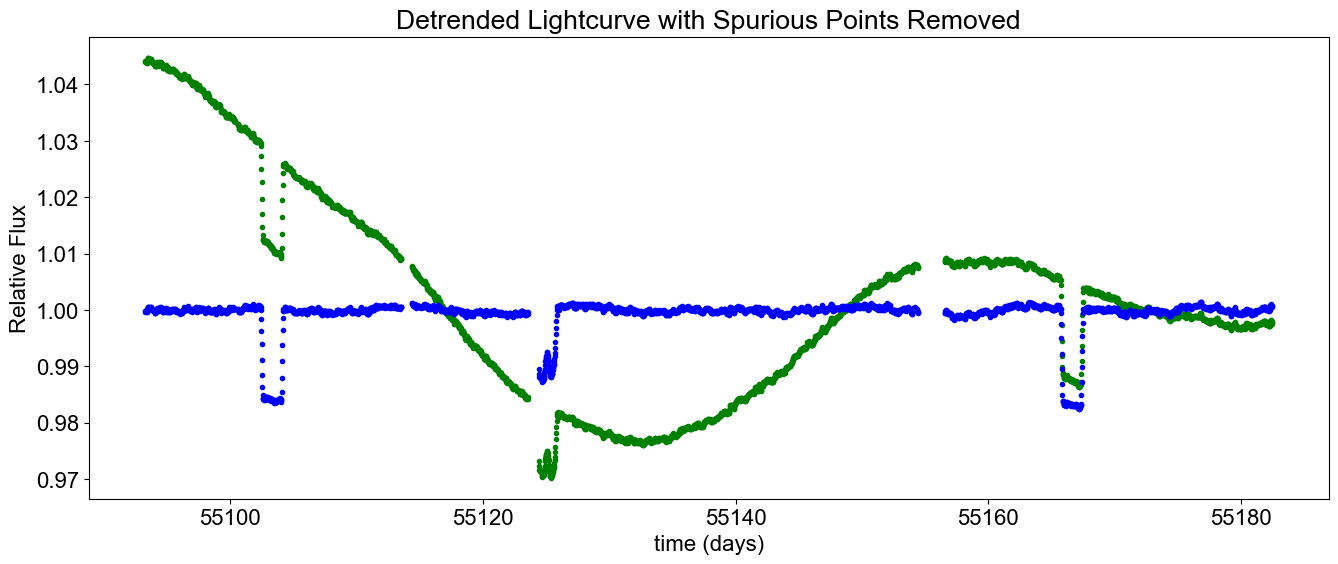

/Users/user/Stars/objects/rg/gaulme/8430105/raw_data/kplr008430105-2013098041711_llc.dat
start time of data =  56390.9590893
end time of data =  56305.1174401
371 datapoints culled
17 datapoints culled
3 datapoints culled
0 datapoints culled


/Users/user/Stars/objects/rg/gaulme/8430105/raw_data/kplr008430105-2009259160929_llc.dat
start time of data =  55091.4675668
end time of data =  55002.7653042
154 datapoints culled
10 datapoints culled
0 datapoints culled


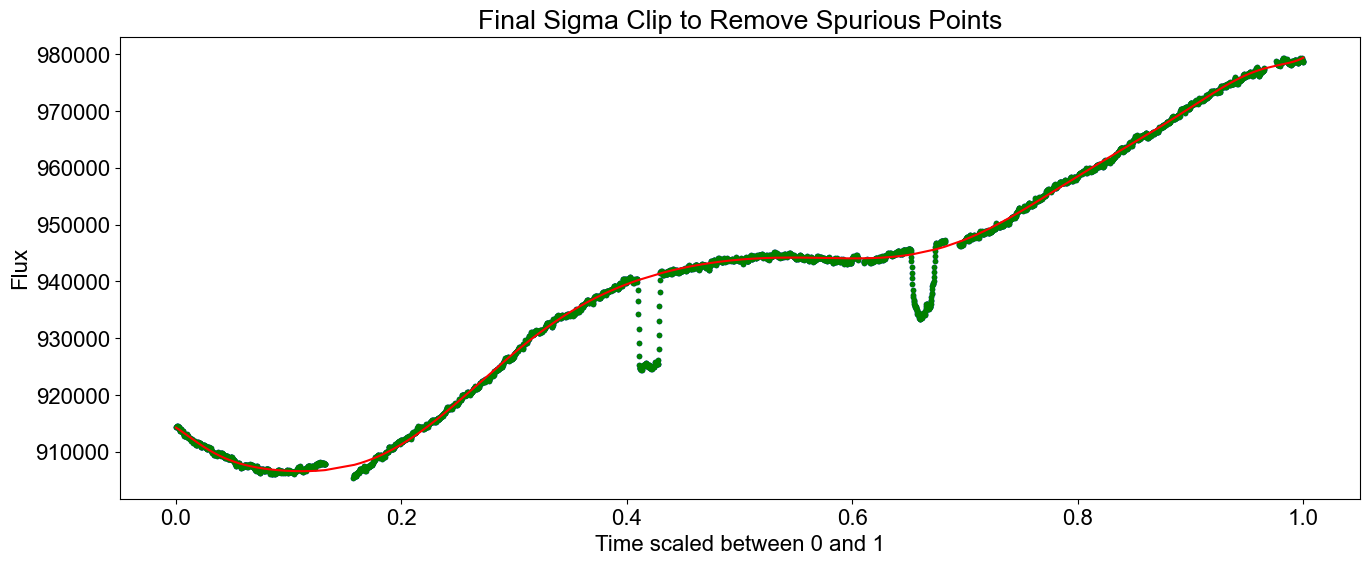

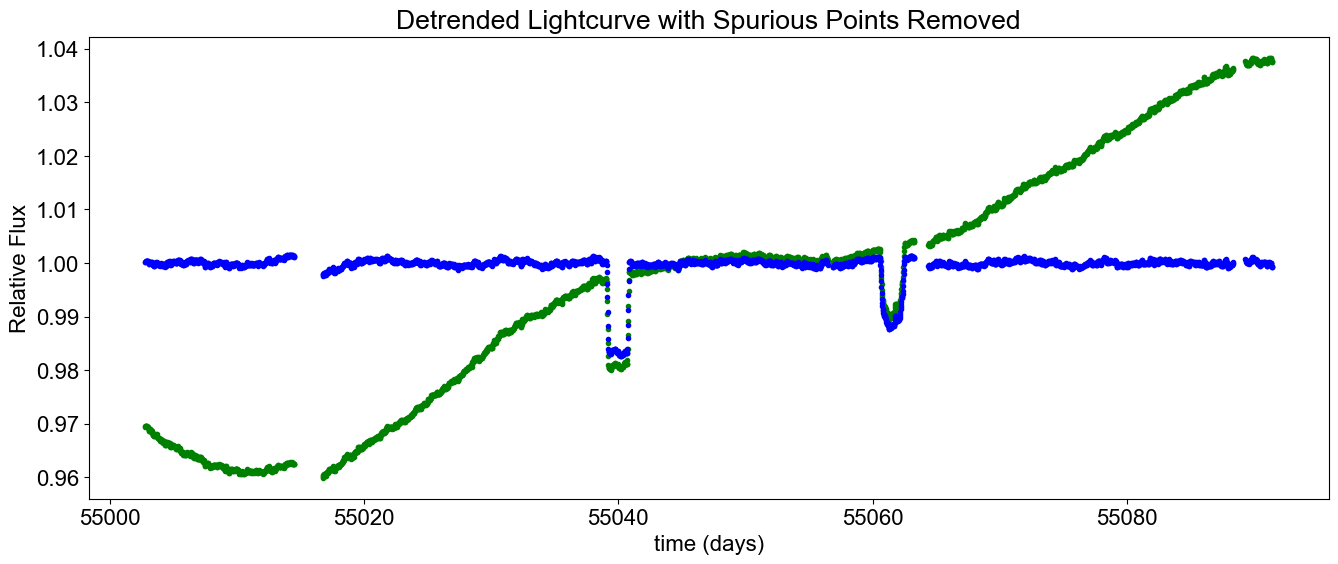

/Users/user/Stars/objects/rg/gaulme/8430105/raw_data/kplr008430105-2010355172524_llc.dat
start time of data =  55552.5482854
end time of data =  55463.1955784
243 datapoints culled
11 datapoints culled
0 datapoints culled


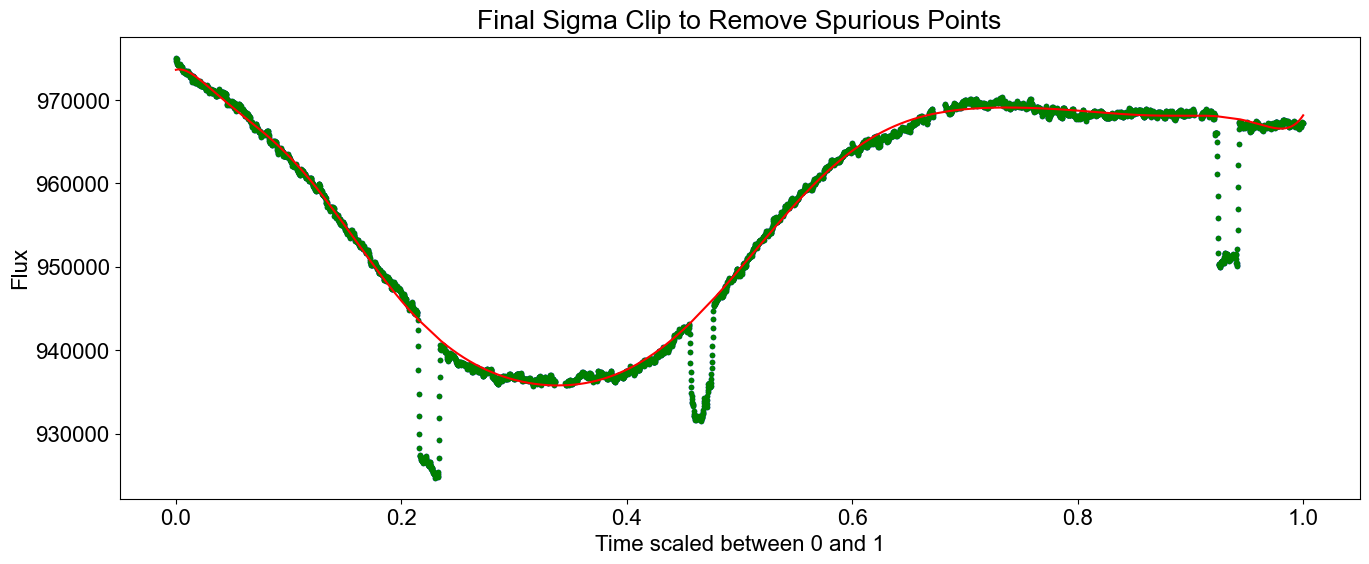

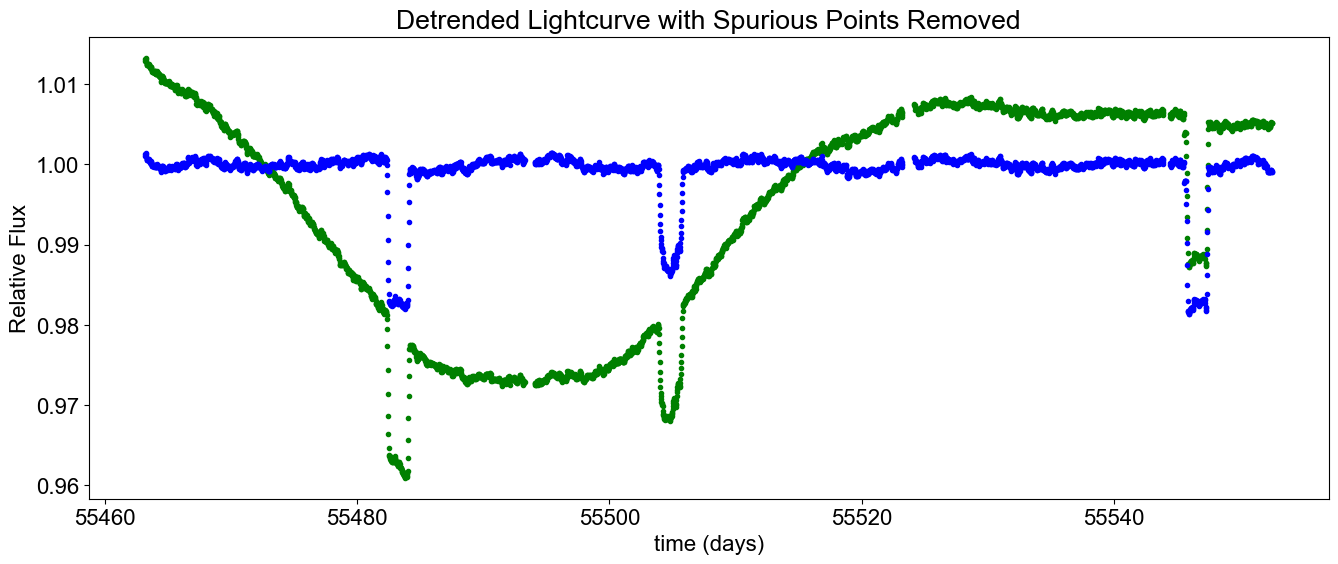

In [16]:
with open(all_detrended, 'w') as outfile:

    for i, file_name in enumerate (glob.glob((files+r"/kplr*dat"))):
        print(file_name)
        with open(file_name) as infile:
            lc = np.loadtxt(infile)
            all_data = detrend(lc)
            if (i == 0):
                complete = all_data
            else:
                complete = np.append(complete,all_data,axis=0)


Sort and prepare data to save

In [17]:
arg=np.argsort(complete[:,0])
complete[:,0]=complete[:,0][arg]
complete[:,1]=complete[:,1][arg]
complete[:,2]=complete[:,2][arg]
complete.transpose()

array([[5.49535390e+04, 5.49535594e+04, 5.49535799e+04, ...,
        5.64239605e+04, 5.64239809e+04, 5.64240014e+04],
       [1.00022713e+00, 1.00026203e+00, 1.00025092e+00, ...,
        9.99527466e-01, 9.99296552e-01, 9.99449041e-01],
       [2.61271733e-05, 2.61289942e-05, 2.61300913e-05, ...,
        2.62762765e-05, 2.62765916e-05, 2.62763502e-05]])

Plot the final data

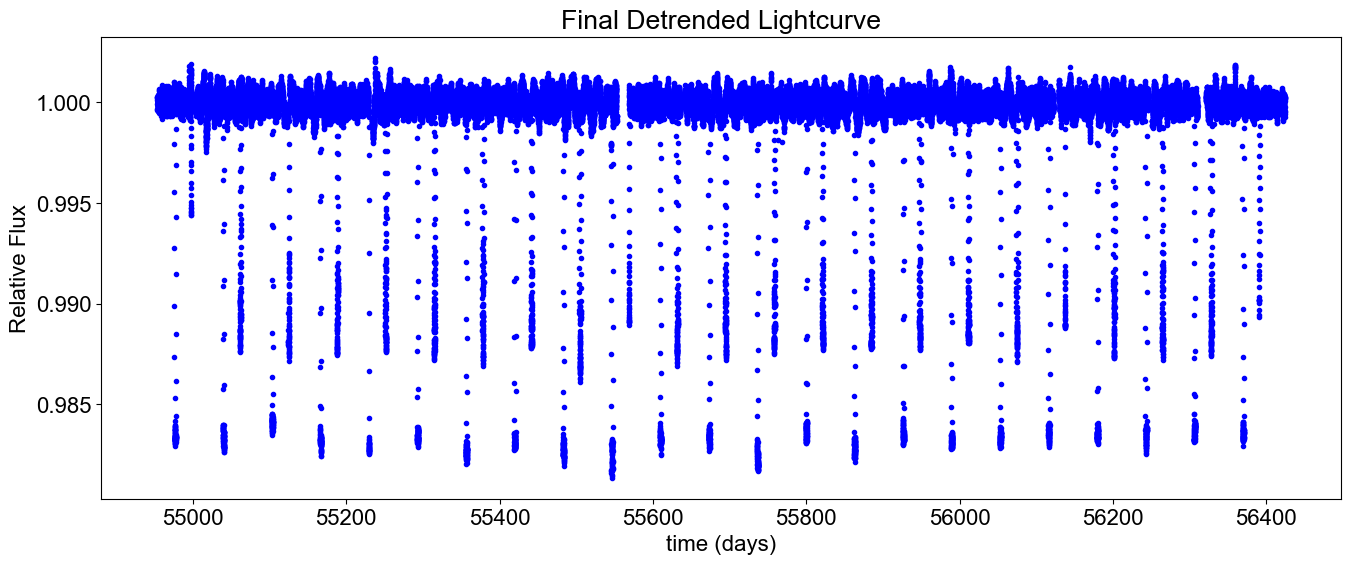

In [18]:
plt.plot(complete[:,0], complete[:,1], 'b.')
plt.title("Final Detrended Lightcurve")
plt.xlabel("time (days)")
plt.ylabel("Relative Flux")
plt.show()

In [19]:
np.savetxt(localdir+'/data/detrended_aggressive.dat',complete,fmt=('%16.10f %10.9f %9.8f'))

In [13]:
print(len(complete))

65263
